<h1 align="center"><font color='gray'>Importing Libraries</font></h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN


# Set style
sns.set_style("whitegrid")

<h1 align="center"><font color='gray'>Dataset Overview</font></h1>

In [2]:
df = pd.read_csv("/kaggle/input/customer-behavior-analytcis/customer_behavior_analytcis.csv")
df.set_index("customer_id", inplace=True)

In [3]:
df.head()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts
customer_id,,,,,
CM00000,7.0,129.34,52.17,18.0,0.0
CM00001,22.0,24.18,9.19,15.0,7.0
CM00002,2.0,32.18,90.69,50.0,2.0
CM00003,25.0,26.85,11.22,16.0,10.0
CM00004,7.0,125.45,34.19,30.0,3.0


In [4]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows in df: {duplicates}")

Number of duplicate rows in df: 0


In [5]:
df.describe().round(2)

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts
count,979.00,979.00,999.00,979.00,999.00
mean,11.57,75.46,49.35,28.24,4.31
std,7.02,55.07,32.73,16.30,4.53
min,0.00,10.26,5.12,4.00,0.00
25%,6.00,33.13,22.38,16.00,1.00
50%,10.00,49.38,40.36,21.00,2.00
75%,17.00,121.26,77.17,45.00,8.00
max,32.00,199.77,119.82,73.00,21.00


In [6]:
def current_stat(df):
    describe = pd.DataFrame(index=df.columns.to_list())
    describe['types'] = df.dtypes
    describe['count'] = df.count()
    describe['nunique'] = df.nunique()
    describe['null'] = df.isnull().sum()
    return describe

In [7]:
current_stat(df)

,types,count,nunique,null
total_purchases,float64,979,32,20
avg_cart_value,float64,979,943,20
total_time_spent,float64,999,953,0
product_click,float64,979,64,20
discount_counts,float64,999,21,0


In [8]:
missing_data = pd.DataFrame({
    'total_missing': df.isnull().sum(), 
    'perc_missing': (df.isnull().sum() / len(df)) * 100  # Convert to percentage
})

missing_data

,total_missing,perc_missing
total_purchases,20,2.002002
avg_cart_value,20,2.002002
total_time_spent,0,0.000000
product_click,20,2.002002
discount_counts,0,0.000000


<h1 align="center"><font color='gray'>Exploratory Data Analysis</font></h1>

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

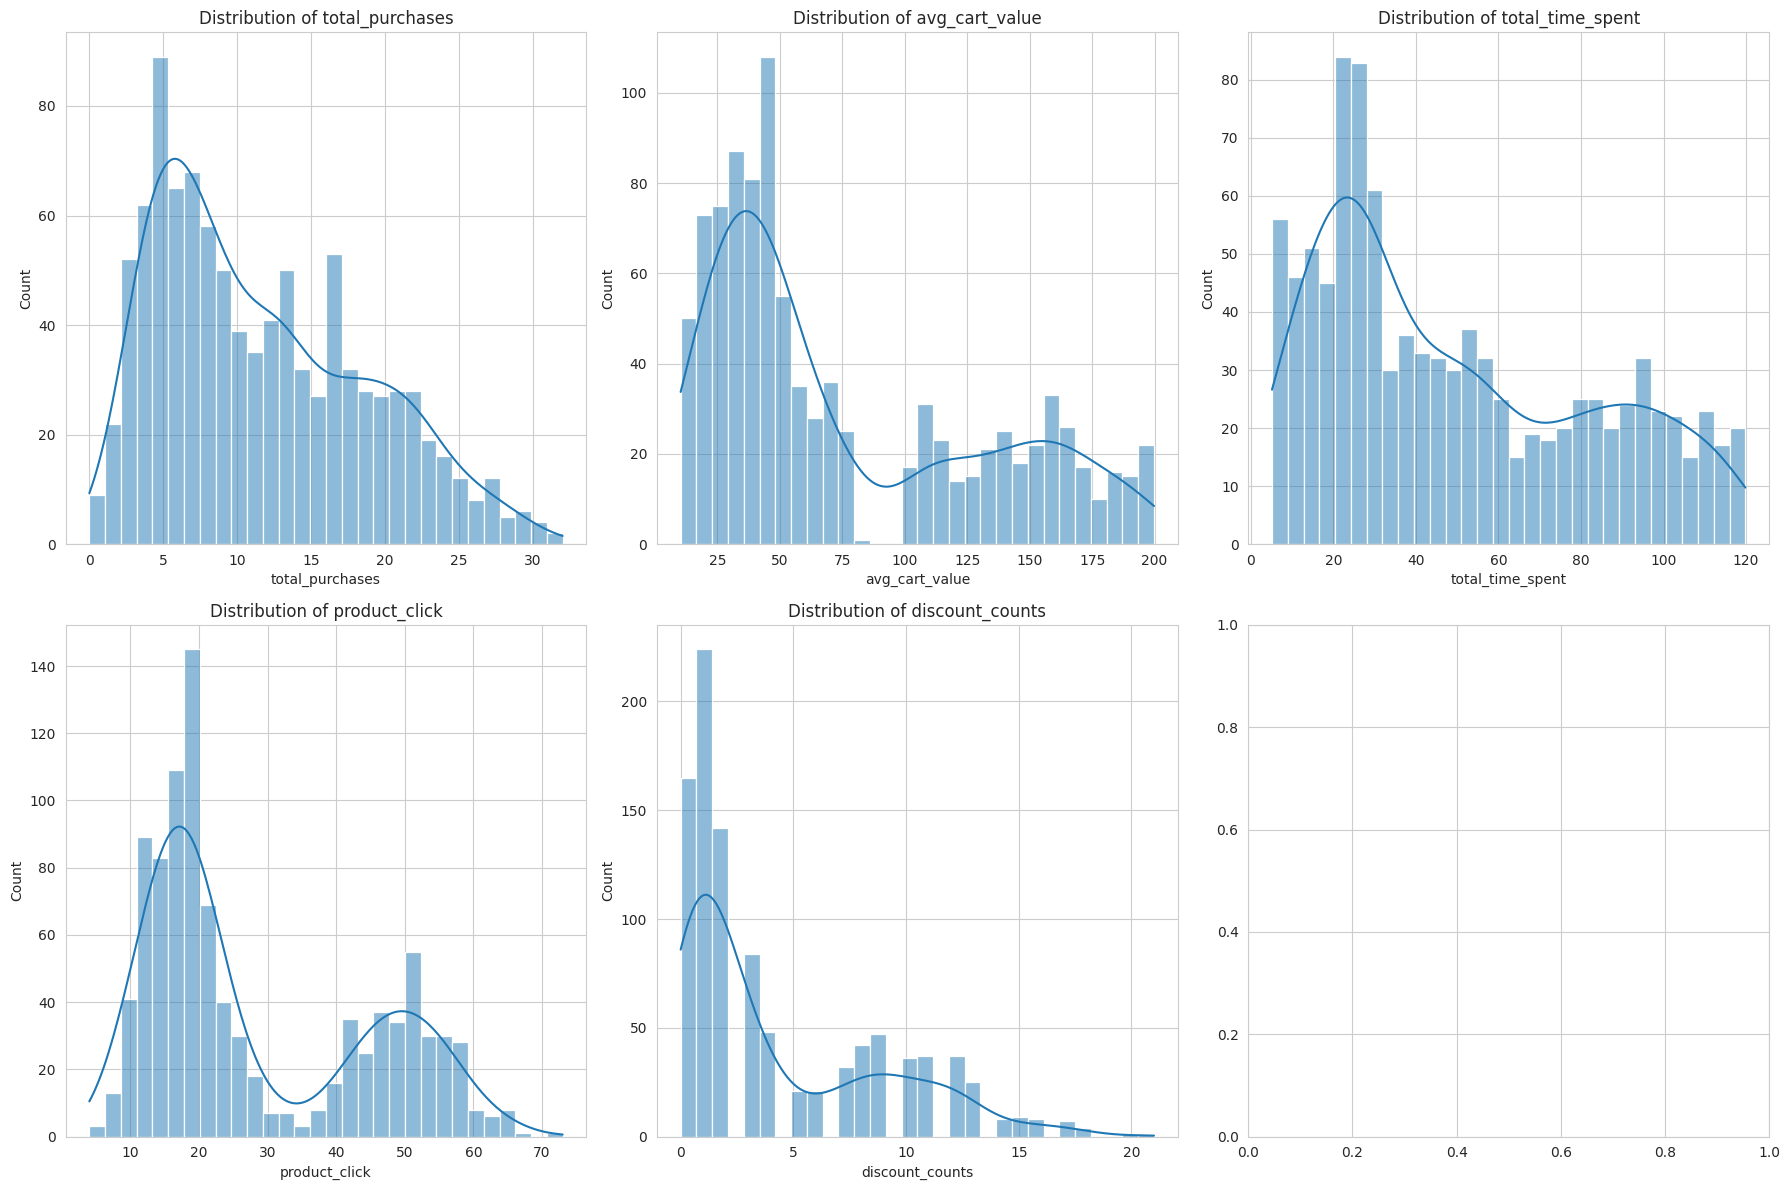

In [9]:
# Plot distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
features = ['total_purchases', 'avg_cart_value', 'total_time_spent', 'product_click', 'discount_counts']

for i, feature in enumerate(features):
    row, col = divmod(i, 3)
    sns.histplot(df[feature], bins=30, kde=True, ax=axes[row, col])
    axes[row, col].set_title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()


In [10]:
def visualize_features(df, col):
    """
    Creates a scatter plot, histogram, and boxplot
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Scatter Plot
    axes[0].scatter(df.index, df[col], alpha=0.6, color='blue')
    axes[0].set_title(f"Scatter Plot of {col}")
    axes[0].set_xlabel("Index")
    axes[0].set_ylabel(col)
    # axes[0].tick_params(axis='x', rotation=90)
    axes[0].set_xticks([])  # Hide x-axis label

    # Histogram
    sns.histplot(df[col], bins=20, kde=True, ax=axes[1], color='green')
    axes[1].set_title(f"Histogram of {col}")

    # Boxplot
    sns.boxplot(x=df[col], ax=axes[2], color='red')
    axes[2].set_title(f"Boxplot of {col}")

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()


### Boxplot of numerical variables

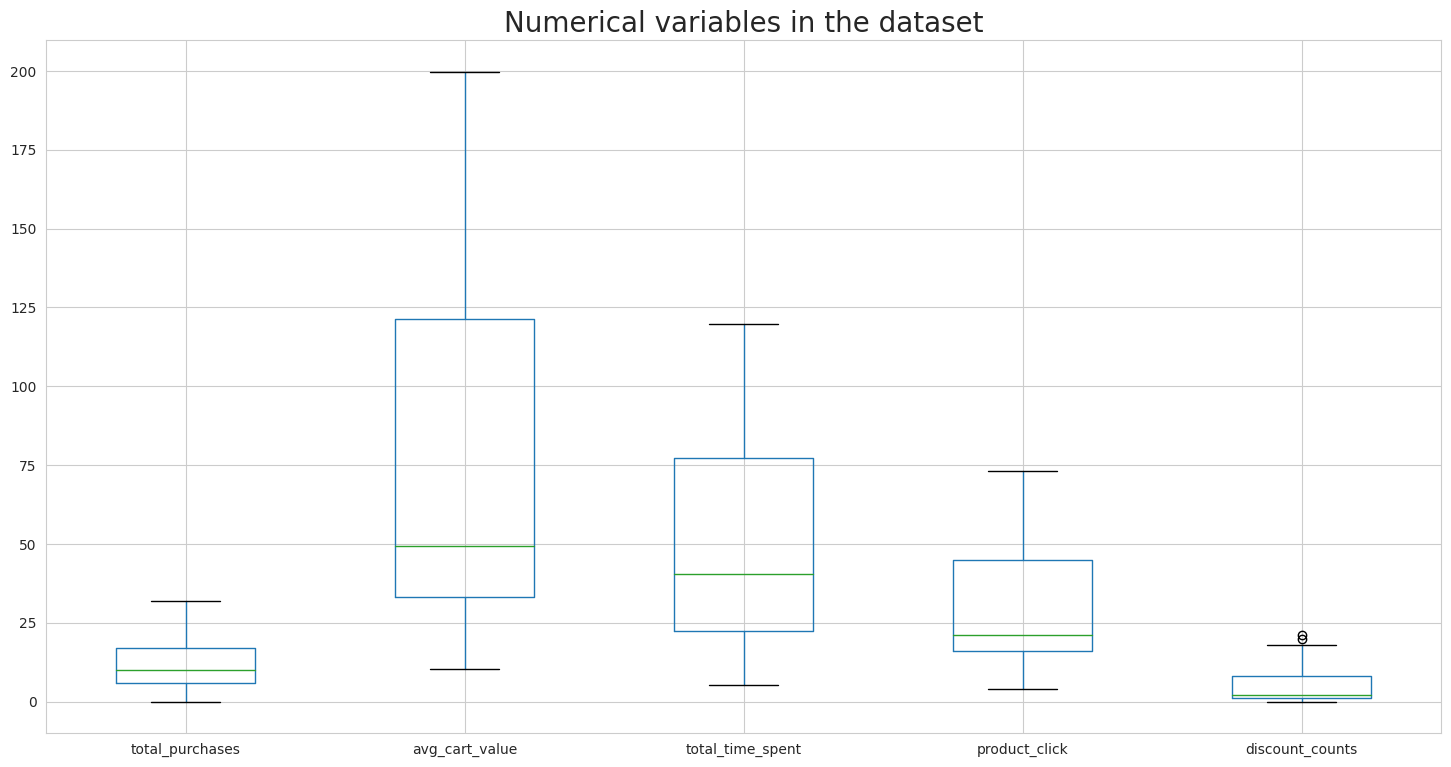

In [11]:
num_cols = ['total_purchases','avg_cart_value','total_time_spent','product_click','discount_counts']
plt.figure(figsize=(18,9))
df[num_cols].boxplot()
plt.title("Numerical variables in the dataset", fontsize=20)
plt.show()

### Handling Outliers

In [12]:
df['discount_counts'].value_counts()

discount_counts
1.0     224
0.0     165
2.0     142
3.0      84
4.0      48
9.0      47
8.0      42
11.0     37
12.0     37
10.0     36
7.0      32
13.0     25
6.0      21
5.0      21
15.0      9
16.0      8
14.0      8
17.0      7
18.0      4
21.0      1
20.0      1
Name: count, dtype: int64

In [13]:
# Get the value counts
value_counts = df['discount_counts'].value_counts(dropna=False)

# Filter the values with counts below 3
below_3 = value_counts[value_counts < 3]

# Calculate percentage
percentage_below_3 = (below_3.sum() / len(df)) * 100

print(f"Percentage of values with counts below 10: {percentage_below_3:.2f}%")

Percentage of values with counts below 10: 0.20%


In [14]:
value_counts = df['discount_counts'].value_counts(dropna=False)

below_3 = value_counts[value_counts < 3].index

median_all = df['discount_counts'].median()

df['discount_counts'] = df['discount_counts'].apply(lambda x: median_all if x in below_3 else x)

<h1 align="center"><font color='gray'>Data Cleaning & Pre-processing</font></h1>

### Handling Missing Data

#### product_click

In [15]:
# Check median vs. mean
print(f"Median: {df['product_click'].median()}")
print(f"Mean: {df['product_click'].mean()}")


Median: 21.0
Mean: 28.23799795709908


In [16]:
df['product_click'].fillna(df['product_click'].median(), inplace=True)


<ipython-input-16-b3caecc6cfb7>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['product_click'].fillna(df['product_click'].median(), inplace=True)


In [17]:
df["product_click"].value_counts()

product_click
21.0    63
17.0    58
18.0    56
19.0    54
16.0    51
        ..
4.0      1
34.0     1
66.0     1
5.0      1
62.0     1
Name: count, Length: 64, dtype: int64

In [18]:
# Get value counts for 'product_click'
value_counts = df['product_click'].value_counts()

# Filter for values with counts below 2
filtered_counts = value_counts[value_counts < 2]

# Count how many values have a count below 2
count_below_2 = filtered_counts.shape[0]

# Total number of entries in the dataset
total_count = df.shape[0]

# Calculate percentage
percentage_below_2 = (count_below_2 / total_count) * 100

# Print the results
print(f"Count of values with frequencies below 2: {count_below_2}")
print(f"Percentage of values with frequencies below 2: {percentage_below_2:.2f}%")


Count of values with frequencies below 2: 8
Percentage of values with frequencies below 2: 0.80%


In [19]:
# Get value counts for 'total_purchases'
value_counts = df['product_click'].value_counts()

# Calculate the median of 'total_purchases'
median = df['product_click'].median()

# Replace values where the count is below 10 with the median
df['product_click'] = df['product_click'].apply(
    lambda x: median if value_counts[x] < 2 else x
)


#### avg_cart_value

In [20]:
df["avg_cart_value"].isnull().sum()

20

In [21]:
# Check median vs. mean
print(f"Median: {df['avg_cart_value'].median()}")
print(f"Mean: {df['avg_cart_value'].mean()}")


Median: 49.38
Mean: 75.4579775280899


In [22]:
df["avg_cart_value"].describe()

count    979.000000
mean      75.457978
std       55.067835
min       10.260000
25%       33.130000
50%       49.380000
75%      121.255000
max      199.770000
Name: avg_cart_value, dtype: float64

In [23]:
df['avg_cart_value'].fillna(df['avg_cart_value'].median(), inplace=True)

<ipython-input-23-8105b6b7fa89>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['avg_cart_value'].fillna(df['avg_cart_value'].median(), inplace=True)


#### total_purchases

In [24]:
# Check median vs. mean
print(f"Median: {df['total_purchases'].median()}")
print(f"Mean: {df['total_purchases'].mean()}")


Median: 10.0
Mean: 11.570990806945863


In [25]:
df["total_purchases"].describe()

count    979.000000
mean      11.570991
std        7.016327
min        0.000000
25%        6.000000
50%       10.000000
75%       17.000000
max       32.000000
Name: total_purchases, dtype: float64

In [26]:
df["total_purchases"].fillna(df["total_purchases"].median(), inplace=True)

<ipython-input-26-1599e918cd60>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["total_purchases"].fillna(df["total_purchases"].median(), inplace=True)


In [27]:
df["total_purchases"].value_counts()

total_purchases
5.0     89
7.0     68
6.0     65
4.0     62
10.0    59
8.0     58
3.0     52
13.0    50
9.0     50
12.0    41
11.0    35
14.0    32
18.0    32
21.0    28
19.0    28
22.0    28
15.0    27
20.0    27
17.0    27
16.0    26
2.0     22
23.0    19
24.0    16
25.0    12
27.0    12
26.0     8
1.0      7
29.0     6
28.0     5
30.0     4
32.0     2
0.0      2
Name: count, dtype: int64

In [28]:
# Get value counts for 'total_purchases'
value_counts = df['total_purchases'].value_counts()

# Filter for values with counts below 10
filtered_counts = value_counts[value_counts < 10]

# Count how many values have a count below 10
count_below_10 = filtered_counts.shape[0]

# Total number of entries in the dataset
total_count = df.shape[0]

# Calculate percentage
percentage_below_10 = (count_below_10 / total_count) * 100

# Print the results
print(f"Count of values with frequencies below 10: {count_below_10}")
print(f"Percentage of values with frequencies below 10: {percentage_below_10:.2f}%")


Count of values with frequencies below 10: 7
Percentage of values with frequencies below 10: 0.70%


In [29]:
# Get value counts for 'total_purchases'
value_counts = df['total_purchases'].value_counts()

# Calculate the median of 'total_purchases'
median_below_10 = df['total_purchases'].median()

# Replace values where the count is below 10 with the median
df['total_purchases'] = df['total_purchases'].apply(
    lambda x: median_below_10 if value_counts[x] < 10 else x
)



In [30]:
df.dtypes

total_purchases     float64
avg_cart_value      float64
total_time_spent    float64
product_click       float64
discount_counts     float64
dtype: object

<h1 align="center"><font color='gray'>Feature Engineering</font></h1>

### EDA via visualizations

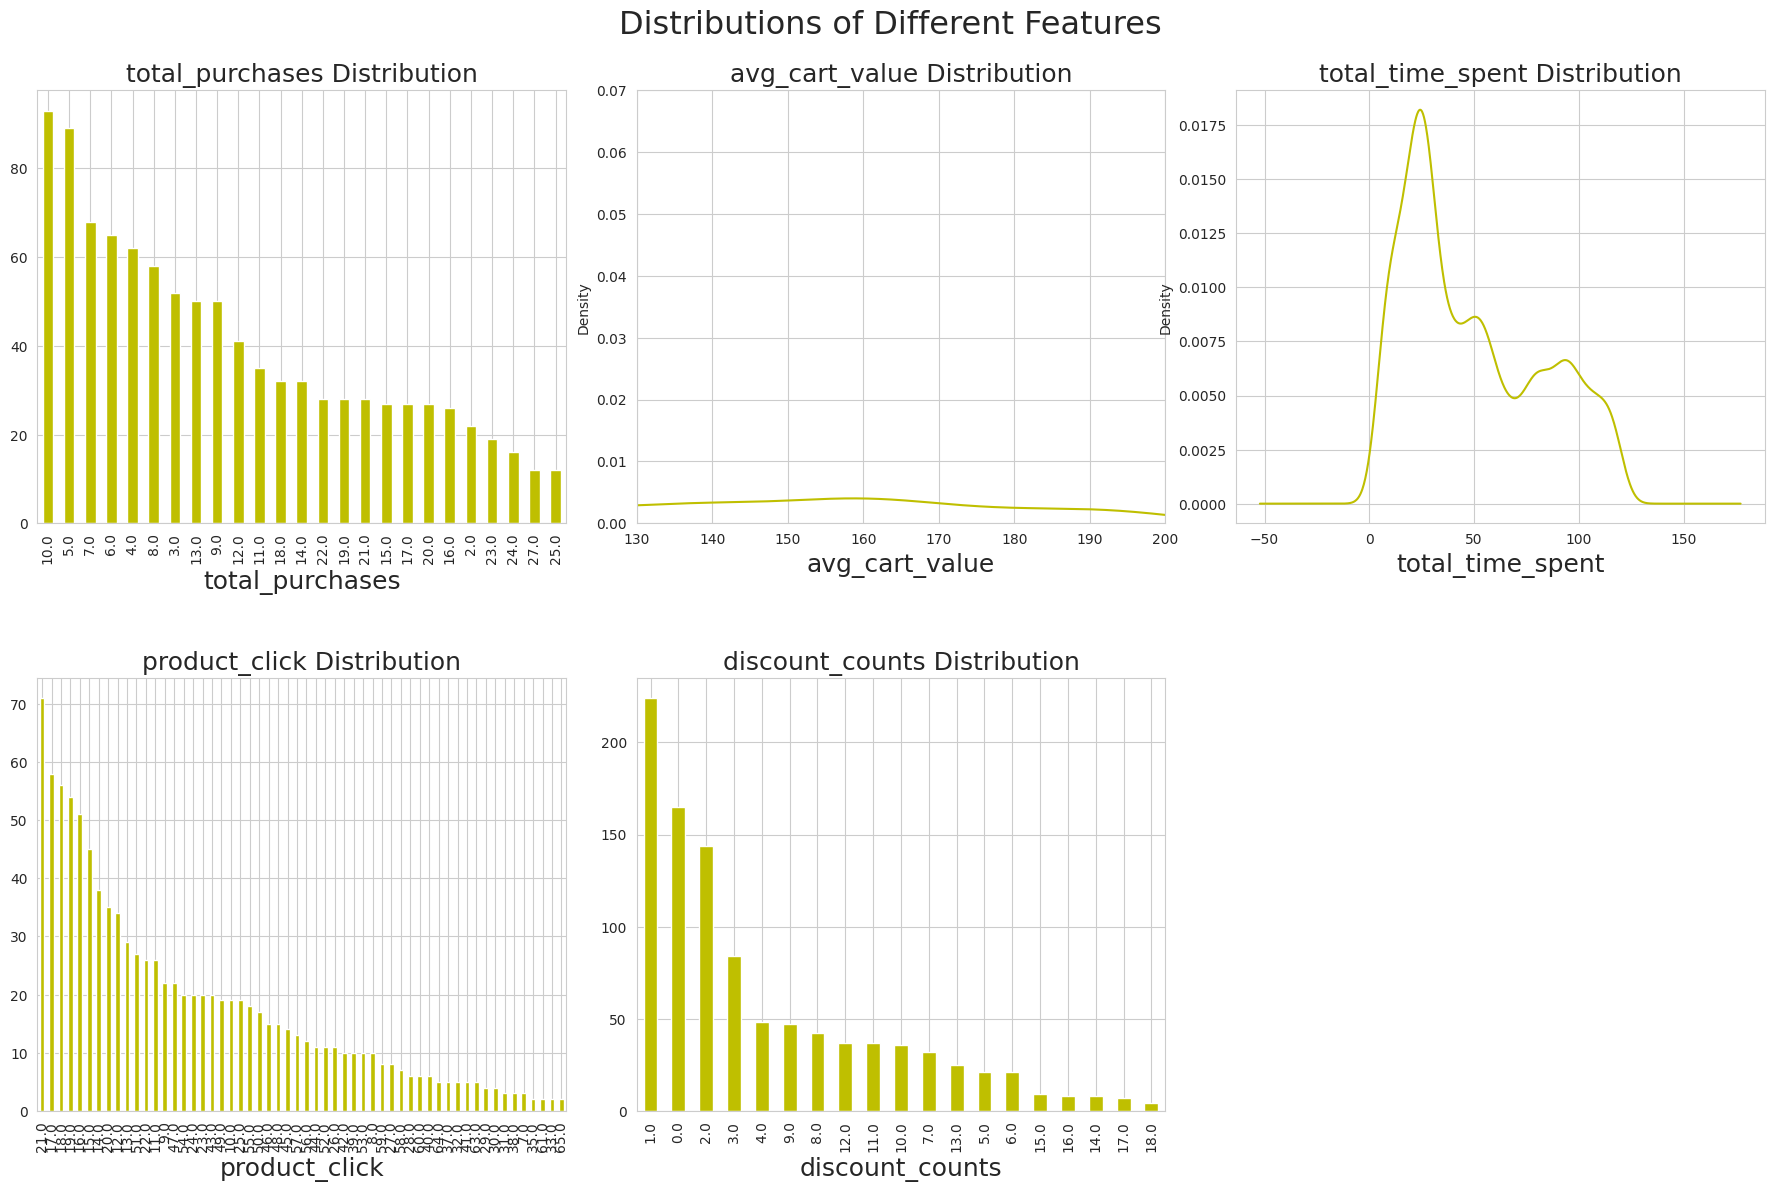

In [31]:
def plot_dist(col, ax):
    if col not in ['avg_cart_value', 'total_time_spent']:  # Fix condition
        df[col].value_counts().plot(kind='bar', facecolor='y', ax=ax)
    else:
        df[col].plot(kind='density', ax=ax, bw_method=0.15, color='y')
        ax.set_xlim(130, 200) if col == 'avg_cart_value' else None  # Adjust limits only for avg_cart_value
        ax.set_ylim(0, 0.07) if col == 'avg_cart_value' else None  
    
    ax.set_xlabel(col, fontsize=18)
    ax.set_title(f"{col} Distribution", fontsize=18)

# Define figure and axes
fig, ax = plt.subplots(2, 3, figsize=(18, 12))  # Adjusted for 5 columns
fig.tight_layout(h_pad=9, w_pad=2, rect=[0, 0.03, 1, 0.93])

# Columns to plot
cols = ['total_purchases', 'avg_cart_value', 'total_time_spent', 'product_click', 'discount_counts']
k = 0

# Iterate over subplots
for i in range(2):
    for j in range(3):
        if k < len(cols):  # Avoid index out of range
            plot_dist(cols[k], ax[i, j])  # Fixed subplot indexing
            k += 1
        else:
            ax[i, j].axis('off')  # Hide extra subplots

# Add title
plt.suptitle("Distributions of Different Features", fontsize=23)

# Show plot
plt.show()


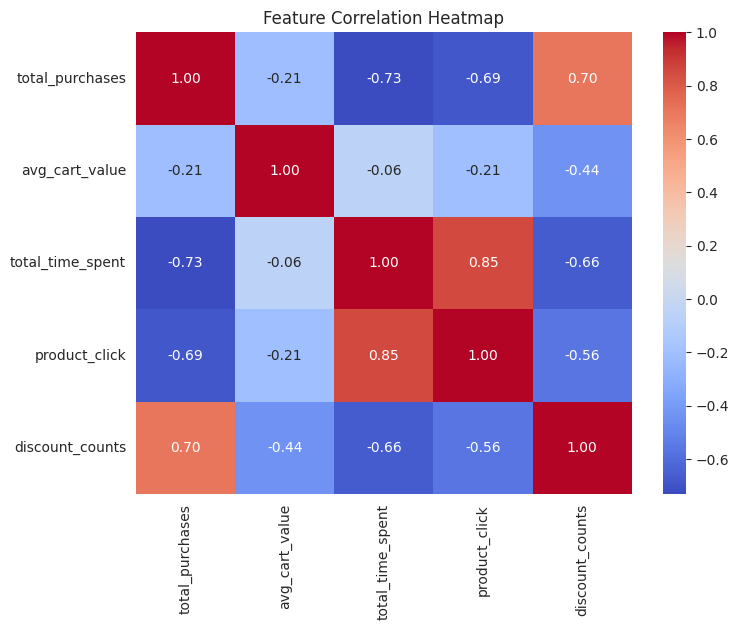

In [32]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [33]:
print(df[cols].skew())

total_purchases     0.611695
avg_cart_value      0.816758
total_time_spent    0.564760
product_click       0.726388
discount_counts     1.041357
dtype: float64


#### log transformation

In [34]:
# Apply log transformation to skewed columns
skewed_cols = ['total_purchases', 'avg_cart_value', 'total_time_spent', 'product_click', 'discount_counts']
df[skewed_cols] = df[skewed_cols].apply(lambda x: np.log1p(x))

In [35]:
print(df.skew())


total_purchases    -0.222620
avg_cart_value      0.010039
total_time_spent   -0.416660
product_click       0.233059
discount_counts     0.106227
dtype: float64


### Feature Scaling

In [36]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the features
df_scaled = scaler.fit_transform(df[skewed_cols])

# Convert to DataFrame for easier handling
df_scaled = pd.DataFrame(df_scaled, columns=skewed_cols)


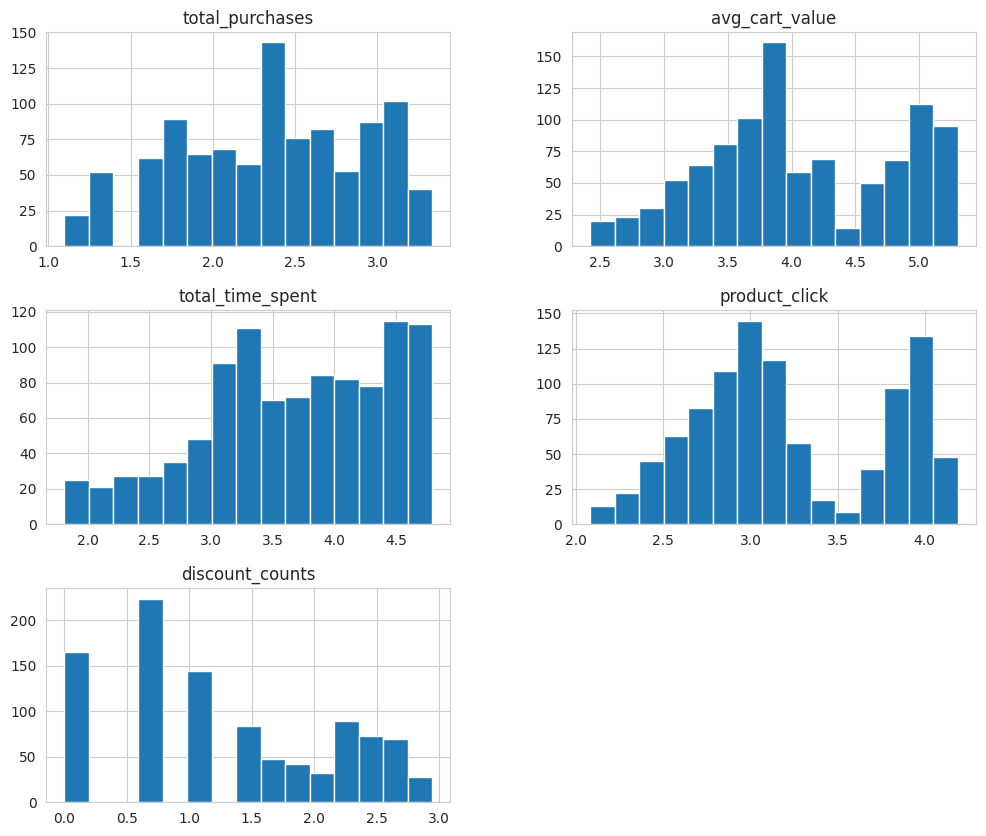

In [37]:
# Plot histograms to visualize the distributions after transformation
df[['total_purchases', 'avg_cart_value', 'total_time_spent', 'product_click', 'discount_counts']].hist(bins=15, figsize=(12, 10))
plt.show()


<h1 align="center"><font color='gray'>Model Selection</font></h1>

### K-Means Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.5307


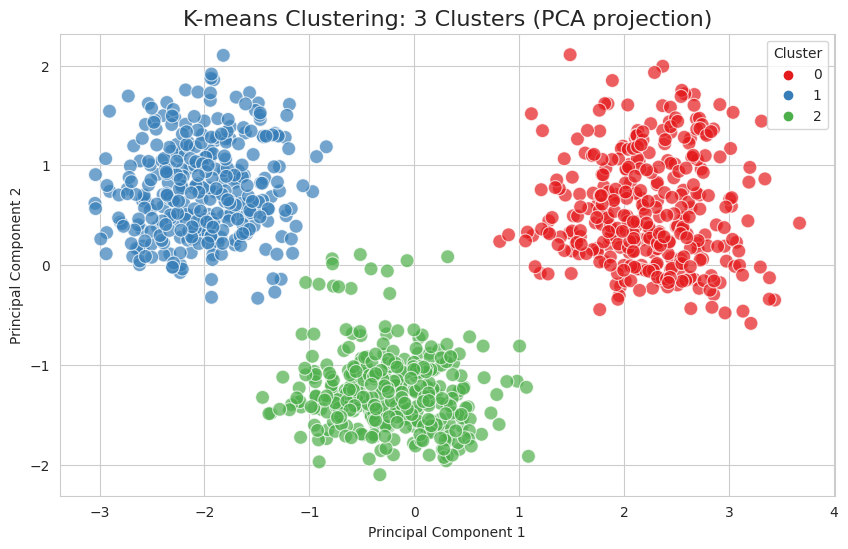

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

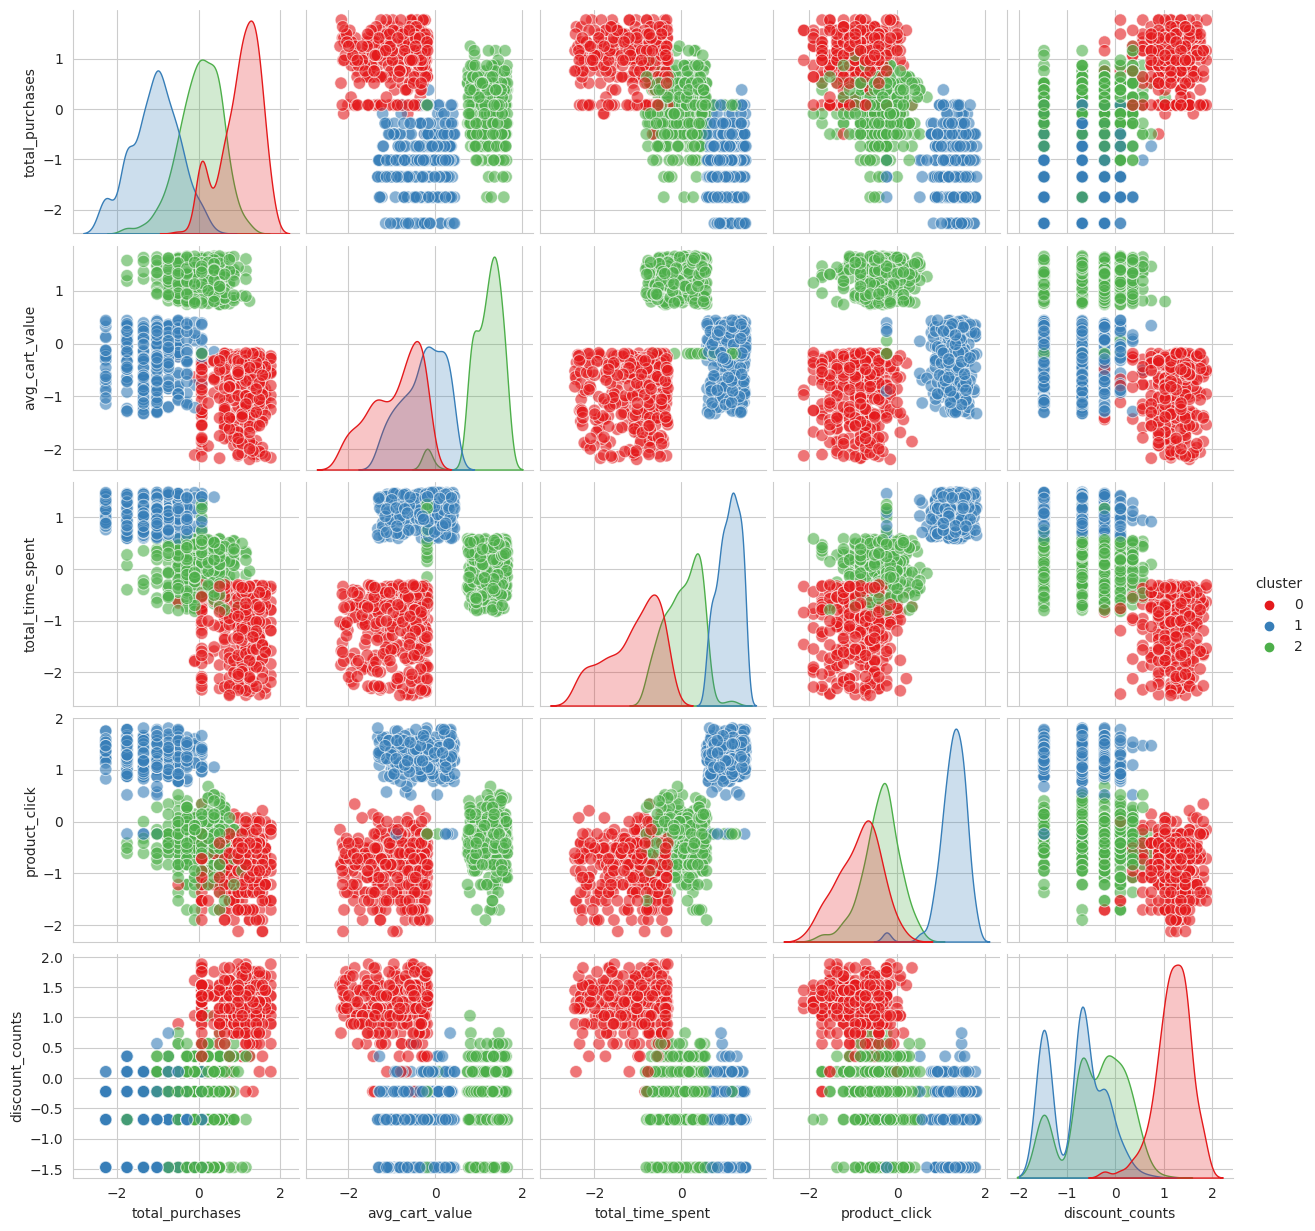

In [38]:
# Set the number of clusters to 3 (based on the problem description)
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model to the standardized and transformed data
kmeans.fit(df_scaled)

# Get the cluster labels for each data point
df_scaled['cluster'] = kmeans.labels_

# Evaluate the clustering using silhouette score
sil_score = silhouette_score(df_scaled[num_cols], kmeans.labels_)
print(f'Silhouette Score: {sil_score:.4f}')

# Plot the clusters in a 2D scatter plot using the first two principal components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled[num_cols])

plt.figure(figsize=(10, 6))
sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1], hue=df_scaled['cluster'], palette="Set1", s=100, alpha=0.7)
plt.title('K-means Clustering: 3 Clusters (PCA projection)', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Optional: Show a pairplot to see the relationships between variables and clusters
sns.pairplot(df_scaled, hue='cluster', palette="Set1", vars=num_cols, plot_kws={'alpha':0.6, 's':80})
plt.show()


<h1 align="center"><font color='gray'>Model Evaluation</font></h1>

In [39]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['total_purchases', 'avg_cart_value', 'total_time_spent', 'product_click', 'discount_counts'])
centroids

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts
0,1.019180,-0.915064,-1.111677,-0.867816,1.190248
1,-1.068672,-0.279868,1.091951,1.269026,-0.805008
2,0.032951,1.173115,0.035586,-0.376503,-0.391450


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

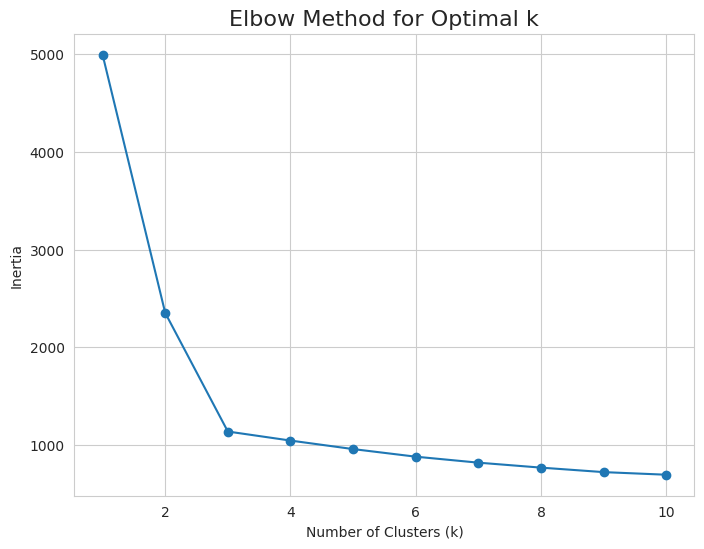

In [40]:
# Inertia calculation for different values of k (from 1 to 10)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled[num_cols])
    inertia.append(kmeans.inertia_)

# Plot the inertia to visualize the elbow
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal k", fontsize=16)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()


In [41]:
df_scaled.groupby("cluster").mean()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts
cluster,,,,,
0,1.019180,-0.915064,-1.111677,-0.867816,1.190248
1,-1.068672,-0.279868,1.091951,1.269026,-0.805008
2,0.032951,1.173115,0.035586,-0.376503,-0.391450


In [42]:
df_scaled.head()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts,cluster
0,-0.496076,1.079438,0.403520,-0.510570,-1.475577,2
1,1.410303,-1.115565,-1.773104,-0.830034,0.894853,0
2,-2.266661,-0.747219,1.121450,1.324948,-0.223229,1
3,1.631623,-0.981011,-1.533758,-0.717335,1.257870,0
4,-0.496076,1.038986,-0.140255,0.399483,0.104710,2



* Cluster 0 → Bargain Hunters
* Cluster 1 → High Spenders
* Cluster 2 → Window Shoppers
